# Тестовое задание

**Обнаружение цели на матрице "Дальность-скорость"**

## Описание:

Работа будет происходить с изображениями размером 32x400 пикселей со случайными объектами (по размеру, форме и интенсивности). Интенсивность объектов: 10-50 из 255. 

Объекты могут быть различных форм и размеров, их можно хоть кисточкой в фотошопе нарисовать. 

Объекты находятся на фоне шума. Средняя интенсивность шума – такая же (или почти такая же) как у объектов. Это важно, чтобы объекты не выделялись на фоне просто пороговой обработкой. 

### Пример визуализации изображения

Для удобства изображение сжимается по одной оси и растягивается по другой, а также изменяются единицы измерения – не пиксели, а метры на м/с

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

%matplotlib inline

In [2]:
GENERATOR_NOISE_RATIO = 0.7
GENERATOR_NUM_BLOBS = 3
MEDIAN_FILTER_KERNEL_SIZE = 3
GRAYSCALE_THRESHOLD = 130
MORPHOLGY_KERNEL_WIDTH = 5
EROSION_ITERATIONS = 3
CONTOUR_LENGHT_THRESHOLD = 5

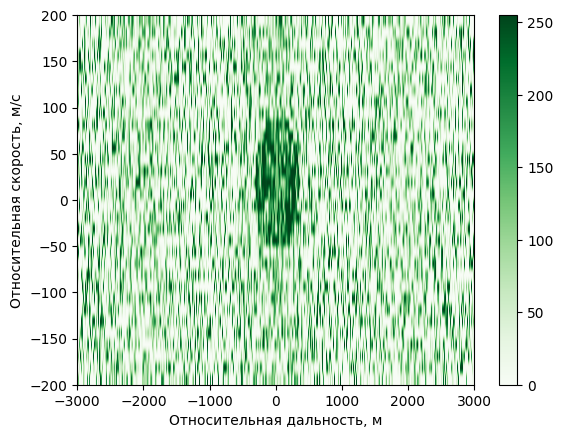

In [3]:
# Set the bounding box, i.e., the extent of the image
# You should use the actual values of the radar sensor
# to estimate the ellipses
extent = (-3000, 3000, -200, 200)
img = np.zeros((32, 400))

# Set the noise level
noise_level = 255 * GENERATOR_NOISE_RATIO

# Generate blob-like object of random shape at the center of the image
# The object is constructed of a number of circles with random radii
# crowded together around the object centroid
obj_x = np.random.randint(img.shape[1]/2-10, img.shape[1]/2+10)
obj_y = np.random.randint(img.shape[0]/2-5, img.shape[0]/2+5)
num_blobs = GENERATOR_NUM_BLOBS
objects = []
for blob in range(num_blobs):
    # Object centroid coordinates
    x = obj_x + np.random.randint(-20, 20)
    y = obj_y + np.random.randint(-5, 5)
    # Object radius    
    r = np.random.randint(5, 20)
    objects.append((x, y, r))
    # Generate the blob
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ((i - y)**2)*10 + (j - x)**2 <= r**2:
                # The object is a bright spot defined as a gaussian blob    ellipses
                img[i, j] = 255
# Add some gaussian blur to the object
img = np.random.normal(img, noise_level)
# Clip the values to the valid range
img = np.clip(img, 0, 255)

# Visualise the result
plt.imshow(img, cmap='Greens', aspect='auto', extent=extent)
plt.xlabel("Относительная дальность, м")
plt.ylabel("Относительная скорость, м/с")
plt.colorbar()
plt.show()

## Задание

1. Используя методы обработки изображений, нужно обнаружить сгенерированные объекты и обвести их эллипсами.

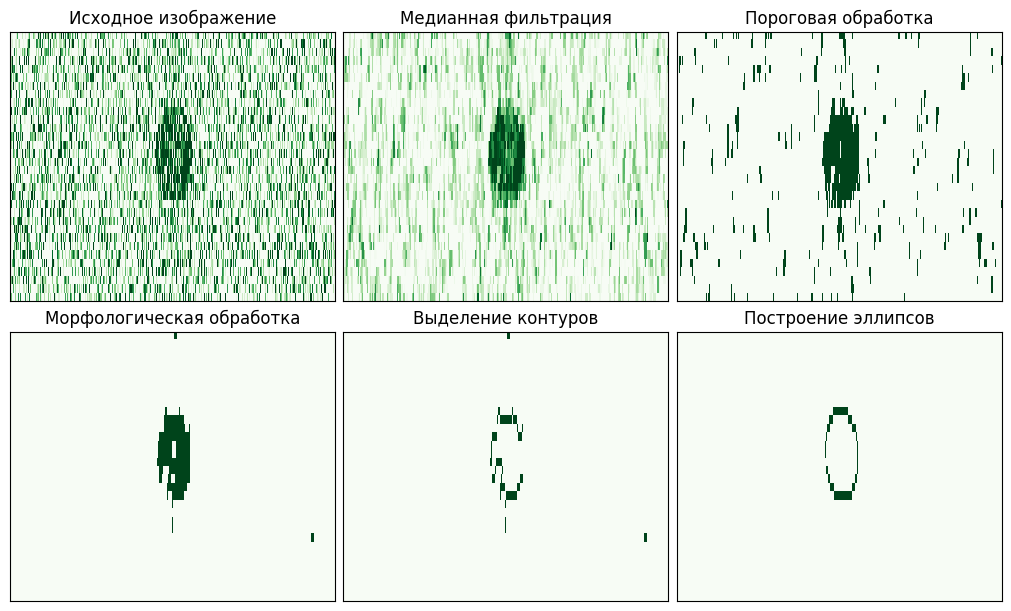

In [4]:
base_img = img

# Median filtration
kernel_size = MEDIAN_FILTER_KERNEL_SIZE
median_img = ndimage.median_filter(base_img.astype(float), kernel_size).astype(np.uint8)

# Threshold the image
ret, threshold_img = cv2.threshold(median_img, GRAYSCALE_THRESHOLD, 255, cv2.THRESH_BINARY)

# Create wide kernel for erosion
dim = MORPHOLGY_KERNEL_WIDTH
kernel = np.zeros((dim, dim), np.uint8)
kernel[dim // 2, :] = np.ones((1, dim), np.uint8)

# Erosion
eroded_img = cv2.erode(threshold_img, kernel, EROSION_ITERATIONS)

# Find contours
contours, hierarchy = cv2.findContours(eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_img = np.zeros_like(eroded_img)
cv2.drawContours(contour_img, contours, -1, (255), 1)

# Fit ellipses
ellipse_img = np.zeros_like(eroded_img)
ellipses = []    
for contour in contours:
    if len(contour) >= CONTOUR_LENGHT_THRESHOLD:
        ellipse = cv2.fitEllipse(contour)
        ellipses.append(ellipse)
        cv2.ellipse(ellipse_img, ellipse, (255), 1)

# Create plot ellipses
fig, axs = plt.subplots(2, 3, figsize=(10, 6), layout='constrained')

def plot_at(ax, image, title):
    ax.imshow(image, cmap='Greens', aspect='auto', interpolation='none')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plot_at(axs[0][0], base_img, "Исходное изображение")
plot_at(axs[0][1], median_img, "Медианная фильтрация")
plot_at(axs[0][2], threshold_img, "Пороговая обработка")
plot_at(axs[1][0], eroded_img, "Морфологическая обработка")
plot_at(axs[1][1], contour_img, "Выделение контуров")
plot_at(axs[1][2], ellipse_img, "Построение эллипсов")

2. Посчитать метрики:
  - Количество пикселей обнаруженного объекта внутри эллипса
  - Количество пикселей обнаруженного объекта вне эллипса
  - Процент заполненности данного эллипса (доля пикселей внутри/вне эллипса)
  - Расстояние между центром эллипса и центром объекта
  - Площадь эллипса

In [5]:
# Creating function to define point in ellipse
def point_in_ellipse(x, y, center, axis, angl):
    xe, ye = center
    a, b = axis

    if a < b:
        a, b = b, a  
        
    f = np.sqrt(a**2 - b**2)

    foc1_x = xe + f * np.cos(angl)
    foc1_y = ye + f * np.sin(angl)
    foc2_x = xe - f * np.cos(angl)
    foc2_y = ye - f * np.sin(angl)
    
    dist1 = np.sqrt((x - foc1_x)**2 + (y - foc1_y)**2)
    dist2 = np.sqrt((x - foc2_x)**2 + (y - foc2_y)**2)
    
    return dist1 + dist2 <= 2 * a

# Creating function to define point in object
def point_in_obj(x, y, xo, yo, r):
    return (x - xo)**2 + ((y - yo)**2)*10 <= r**2

# Creating dictionaries for metrics
pixels_in = dict()
pixels_out = dict()
percents = dict()
distances = dict()
area = dict()
objs = dict()

# Initialize metrics for each ellipse
for i, ellipse in enumerate(ellipses):
    pixels_in[i] = 0
    pixels_out[i] = 0
    percents[i] = 0
    distances[i] = list()
    objs[i] = list()
    area[i] = np.pi * (ellipse[1][0] / 2) * (ellipse[1][1] / 2)  # Area of ellipse

# define if this object belong to this ellipse
if len(ellipses) > 1:
    for k, elps in enumerate(ellipses):
        distance_list = []
        
        for obj in objects:        
            d = float(np.sqrt((obj[0] - elps[0][0])**2 + (obj[1] - elps[0][1])**2))
            distance_list.append(d)
            
        for t, obj in enumerate(objects):
            d = distance_list[t]
            if d < np.average(distance_list):
                objs[k].append(obj)
                distances[k].append(d)
else:
    for elps in ellipses:
        for obj in objects:
            d = float(np.sqrt((obj[0] - elps[0][0])**2 + (obj[1] - elps[0][1])**2))
            objs[0].append(obj)
            distances[0].append(d)

# Count metrics
for k, elps in enumerate(ellipses):
    
    for m, obj in enumerate(objs[k]):
            
        for j in range(img.shape[0]):  # Loop over rows (height)
            for i in range(img.shape[1]):  # Loop over columns (width)
                # Check if the point (i, j) is inside the object and the ellipse
                if point_in_obj(i, j, *obj) and point_in_ellipse(i, j, *elps):
                    pixels_in[k] += 1
                elif point_in_obj(i, j, *obj):  # If only inside object
                    pixels_out[k] += 1
        # Count other metrics
        percents[k] = 100 * pixels_in[k] / (pixels_in[k] + pixels_out[k])
        
# Show results
print(f"pixels_in = {pixels_in}")
print(f"pixels_out = {pixels_out}")    
print(f"percents = {percents}")
print(f"distance = {distances}")
print(f"area = {area}")

pixels_in = {0: 651}
pixels_out = {0: 0}
percents = {0: 100.0}
distance = {0: [3.056207473852002, 6.415107936911348, 4.5878386155722035]}
area = {0: 330.3229893548377}


3. Провести с метриками тесты. Посмотреть как интенсивность шума влияет на качество оценки эллипсами, сделать выводы. Попробовать разные изображения с разными объектами (по размеру, форме и интенсивности). Желательно сохранить исходные изображения и изображения с эллипсами.

In [6]:
SAVE_DIRECTORY = "results/"

def save_as(name):
    with open(f"{SAVE_DIRECTORY}{name}.txt", "w") as f:
        f.write(f"Conditions:\n")
        f.write(f"  generator_noise_ratio     = {GENERATOR_NOISE_RATIO}\n")
        f.write(f"  generator_num_blobs       = {GENERATOR_NUM_BLOBS}\n")
        f.write(f"  median_filter_kernel_size = {MEDIAN_FILTER_KERNEL_SIZE}\n")
        f.write(f"  grayscale_threshold       = {GRAYSCALE_THRESHOLD}\n")
        f.write(f"  morphology_kernel_width   = {MORPHOLGY_KERNEL_WIDTH}\n")
        f.write(f"  erosion_iterations        = {EROSION_ITERATIONS}\n")
        f.write(f"  contour_length_threshold  = {CONTOUR_LENGHT_THRESHOLD}\n")
        
        f.write("\n")
        
        f.write(f"Results:\n")
        f.write(f"  pixels_in =  {pixels_in}\n")
        f.write(f"  pixels_out = {pixels_out}\n")    
        f.write(f"  percents =   {percents}\n")
        f.write(f"  distance =   {distances}\n")
        f.write(f"  area = {area}\n")
    fig.savefig(f"{SAVE_DIRECTORY}{name}.png")

In [7]:
save_as("untitled")